In [1]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate, LSTM, Dropout
from keras.models import Model
from keras.optimizers import Adagrad, RMSprop

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, log_loss

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from AttentionLayer import *
from Productive_Data_GetTrainTest import samEval_Taskb

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from AttentionLayer.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath= 'outputs/finalTests/'

In [4]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

In [5]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

In [6]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [14]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


# Data

In [7]:
#Load necessary data
train_data, train_labels, test_data, test_labels,  word_index, MAX_SEQUENCE_LENGTH = samEval_Taskb()

In [8]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

In [18]:
train_pos =get_pos('output_trainTestData/SamEval_B_train_pos_hash.csv')
test_pos = get_pos('output_trainTestData/SamEVal_B_test_pos_hash.csv')

In [19]:
train_senti_blob =get_sentiment('output_trainTestData/SamEval_B_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/SamEval_B_test_data_sentiment_blob.csv')

# The model

In [23]:
#The model
wv_layer = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = wv_layer(comment_input)
x_first = Dense(600, activation='relu')(embedded_sequences)
x_first = Flatten()(x_first)

#Second part
senti_input_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_second = Dense(600, activation='relu')(senti_input_blob)

#Thrid part
senti_input_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_third = Dense(600, activation='relu')(senti_input_pos)

#Concatination
concat = concatenate([x_first, x_second, x_third])

preds = Dense(4, activation='softmax')(concat)

model = Model(inputs=[comment_input, senti_input_blob, senti_input_pos], outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 300)      4127100     input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 40, 600)      180600      embedding_2[0][0]                
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_6 (I

# Test results

In [24]:
#model = Kearas model
#softmax = boolean, true if the model uses softmaxe in the output layer otherwise false
#outputpath = path were the output csv should be stored
#outputname = name to use for the output csv
def train_evaluate_three_inputs_multyclass(model, nrepochs, nrbatch, optimizer, lossfunction, train_data, train_data2, train_data3,
                                train_labels, test_data, test_data2, test_data3, test_labels, softmax, outputpath, outputname):
    import datetime
    
    seed = 7
    np.random.seed(seed)
    tf.set_random_seed(seed)
    rd.seed(seed)
    
    #needed for softmax-activation
    if softmax:
        labelstrain = to_categorical(train_labels)
        labelstest = to_categorical(test_labels)
    else:
        labelstrain = train_labels
        labelstest = test_labels

    time_callback = TimeHistory() 
    terminate = TerminateOnNaN()
    
    #evaluate the positive class (=ironic data)
    precision =km.binary_precision(label=1)
    recall = km.binary_recall(label=1)
    f1 = km.f1_score(label=1)

    model.compile(loss = lossfunction,
          optimizer=optimizer,
          metrics=['accuracy', precision, recall, f1])

    #Train the model 
    hist= model.fit([train_data, train_data2, train_data3], labelstrain, epochs=nrepochs, batch_size=nrbatch, 
                    shuffle=True, verbose = 0, callbacks=[time_callback, terminate])

    from matplotlib import pyplot
    %matplotlib inline
    pyplot.figure(figsize=(15,10))
    pyplot.plot(hist.history['acc']) 
    pyplot.plot(hist.history['f1_score'])
    #pyplot.plot(hist.history['loss'])
    pyplot.xticks(np.arange(1,nrepochs))
    pyplot.legend(['Train Accuracy', 'Train F1', 'Validation Accuracy', 'Validation F1', 'Loss'], loc=(1.04,0.5))
    pyplot.show()       
    
    predictions = model.predict([test_data,test_data2, test_data3], verbose = 0)
    preds=np.argmax(predictions, axis=1)
    print('Accuracy: '+str((accuracy_score(test_labels,preds))*100))
    print('Precision: '+str((precision_score(test_labels,preds,average='macro'))*100))
    print('Recall: '+str((recall_score(test_labels,preds,average='macro'))*100))
    print('F1: '+str((f1_score(test_labels,preds,average='macro'))*100))
    
    #Store the keras model
    model.save(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+'_'+outputname+
                   '_'+'_model.h5')  


    #stores the test results        
    f= open(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+' '+outputname+'_finaltestresults.csv','w+')
    f.write('Accuracy;'+str((accuracy_score(test_labels,preds))*100)+'\n'+
            'Precision;'+str((precision_score(test_labels,preds,average='macro'))*100)+'\n'+
            'Recall;'+str((recall_score(test_labels,preds,average='macro'))*100)+'\n'+
            'F1;'+str((f1_score(test_labels,preds,average='macro'))*100)+'\n')
    f.close() 

Instructions for updating:
Use tf.cast instead.


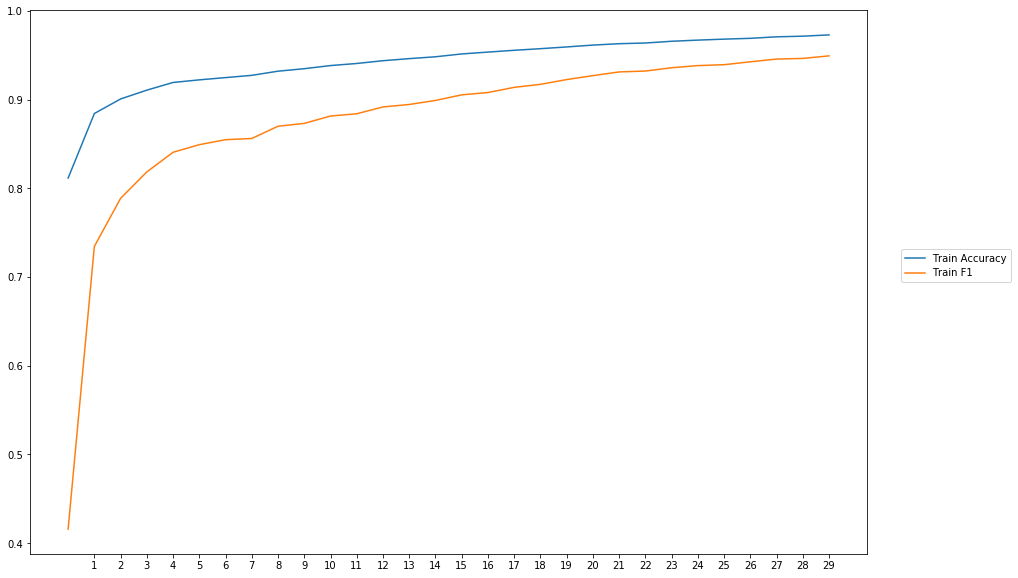

Accuracy: 82.14285714285714
Precision: 63.72960998010194
Recall: 62.400135013210715
F1: 61.32350342912185


In [25]:
train_evaluate_three_inputs_multyclass(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'SamEValB')